# Introdução

Este trabalho tem como objetivo comparar a performance de três rastreadores sobre a categoria de _detection and tracking_ (detecção e rastreamento), [SORT](https://github.com/abewley/sort) (simple online and realtime tracking), Deep SORT e ByteTrack. Os rastreadores serão testados em dois bancos de dados, o [pNEUMA](https://open-traffic.epfl.ch/), dataset contendo videos de 30 minutos de estradas na Grécia capturadas por um conjunto de drones, e um customizado nomeado _city above_, que contém imagens de um drone sobrevoando uma via de carros.

Também serão testados duas redes neurais convolucionais para detecção de objetos, treinadas no dataset [VSAI](https://www.kaggle.com/datasets/dronevision/vsaiv1), sendo elas a _YOLOv7_, que é estado da arte em detecção de objetos e a _YOLOv7-tiny_, versão com menos parâmetros da _[YOLOv7](https://github.com/WongKinYiu/yolov7)_ que sacrifica acurácia por velocidade. As redes foram treinadas 5 vezes, partindo dos pesos do dataset [COCO](https://cocodataset.org/#home), com inputs de tamanho 640x640 pixels.

Uma rodada de testes também foi feita com a _Fast RCNN_, para comparar a rede neural original utilizada nos artigos do _SORT_ e _Deep SORT_.

Todo o código utilizado para gerar os resultados estão disponíveis no [github](https://github.com/samsvp/deep-learning-tracking) e os pesos no [Google Drive](https://drive.google.com/uc?id=1xRwxB8QUFRx6wt5HSEJySCUhbUr3X_j0).

# Metodologia

Para teste dos rastreadores foram utilizados os repositório oficiais do [SORT](https://github.com/abewley/sort), [ByteTrack](https://github.com/ifzhang/ByteTrack) e a seguinte implementação do [Deep SORT](https://github.com/levan92/deep_sort_realtime).

Para os detectores, foram utilizados os repositórios oficias da _[YOLOv7](https://github.com/WongKinYiu/yolov7)_ e a seguinte implementação da _[fastrcnn](https://github.com/sovit-123/fasterrcnn-pytorch-training-pipeline)_. Para a _YOLOv7_ utilizamos os [pesos pré-treinados](https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt) do COCO disponíveis no repositório. Os pesos para versão _tiny_ podem ser encontrados [aqui](https://github.com/WongKinYiu/yolov7). Foram treinadas durante 50 epochs 5 instâncias da versão _tiny_ e 5 instâncias da versão full por 100 epochs. Cada instância teve um split diferente de treino e teste, com 5240 imagens de treino e 2315 de teste.

A _fastrcnn_ utilizou os pesos da _fasterrcnn_resnet50_fpn_ como ponto de partida e foi treinada no dataset do VSAI por 10 iterações em uma P100, com od metaparâmetros padrão do repositório, utilizando as mesmas configurações da _YOLO_.

Para o DeepSORT, foi utilizado como feature extractor a MobilenetV2 treinada no dataset da Imagenet.

O dataset utilizado foi o [VSAI](https://www.kaggle.com/datasets/dronevision/vsaiv1), contendo 5240 imagens de treino, 2315 de teste e 1520 de validação. O dataset contém imagens aérias, capturas por um drone em diversas partes da China, de 49,712 veículos, sendo 47,519 veículos de pequeno porte (e.g. carros) e 2193 veículos de grande porte (e.g. ônibus e caminhões). Foi necessário converter as labels do Dataset para o formato da YOLO e da fastrcnn. O dataset já convertido para a YOLO pode ser encontrado no [drive](https://drive.google.com/uc?id=1xRwxB8QUFRx6wt5HSEJySCUhbUr3X_j0). O código para conversão para formato da fastrcnn é o seguinte (rodar dentro do repo da Fast RCNN):

In [29]:
%%script false --no-raise-error

import os
from PIL import Image
import numpy as np
import pandas as pd


def create_xml(data: str, img_w: int, img_h: int, image_path: str) -> str:
    text = f"""
    <annotation>
	<folder></folder>
	<filename>{image_path}</filename>
	<path>{image_path}</path>
	<source>
		<database>VSAI</database>
	</source>
	<size>
		<width>{img_w}</width>
		<height>{img_h}</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
    """
    for line in data.split("\n"):
        if not line: continue
        
        values = [int(float(v)) for v in line.split(" ")[:8]]
        name = line.split(" ")[8]
        xmax = max([values[i] for i in [0, 2, 4, 6]])
        xmin = min([values[i] for i in [0, 2, 4, 6]])
        ymax = max([values[i+1] for i in [0, 2, 4, 6]])
        ymin = min([values[i+1] for i in [0, 2, 4, 6]])
        ymin = max(0, ymin)
        xmin = max(0, xmin)
        text += f"""
        <object>
		<name>{name}</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>{xmin}</xmin>
			<xmax>{xmax}</xmax>
			<ymin>{ymin}</ymin>
			<ymax>{ymax}</ymax>
		</bndbox>
	</object>
        """
    text += "</annotation>"
    return text

if __name__ == "__main__":
    basedir = "vsaiv1/VSAIv1/split_ss_444_lsv/"
    folders = ["test", "train", "val"]
    for folder in folders:
        if not os.path.exists(f"{folder}"):
            os.mkdir(f"{folder}")
        files = os.listdir(os.path.join(basedir, folder, "images"))
        for i, img_path in enumerate(files):
            full_path = os.path.join(basedir, folder, "images", img_path)
            with open(full_path.replace(".png", ".txt").replace("images", "annfiles")) as fp:
                data = fp.read()
            width, height = Image.open(full_path).size
            
            t = create_xml(data, width, height, full_path)
            with open(f"{folder}/{img_path.replace('.png', '.xml')}", 'w') as fp:
                fp.write(t)
            if i % 200 == 0:
                print(f"[{folder}] {i} out of {len(files)} completed")
    
    print("Done preprocessing")

O arquivo data_configs/custom_data.yaml para treinar é o seguinte:
```yaml
# Images and labels direcotry should be relative to train.py
TRAIN_DIR_IMAGES: 'vsaiv1/VSAIv1/split_ss_444_lsv/train/images'
TRAIN_DIR_LABELS: 'train'
VALID_DIR_IMAGES: 'vsaiv1/VSAIv1/split_ss_444_lsv/test/images'
VALID_DIR_LABELS: 'test'

# Class names.
CLASSES: [
    '__background__',
    'small-vehicle', 'large-vehicle'
]

# Number of classes (object classes + 1 for background class in Faster RCNN).
NC: 3

# Whether to save the predictions of the validation set while training.
SAVE_VALID_PREDICTION_IMAGES: True
```

Para teste do tracking foram utilizados dois datasets, o primeiro sendo a extensão do [pNEUMA](https://open-traffic.epfl.ch/) que contém mais de 1900 imagens em 4K de veículos vistos de um drone em uma região da Grécia anotadas com id e bounding box de cada veículo. As imagens foram capturadas em aproximadamente 2 quadros por segundo. Devido ao tamanho das imagens, focamos em rodar o rastreamento em uma seção da imagem de 1028x512 pixels. Como esta região não contém objetos que possam gerar oclusão dos veículos na pista (e.g. uma àrvore) um vídeo customizado, a 24FPS, chamado de _city\_above_, com algumas regiões de oclusão foi devidamente anotado.

Para anotar o vídeo customizado, foi criada uma ferramenta para auxiliar a gerar dados no formato de MOT. Dado um arquivo com rastreamentos parciais é possível deletar rastreamentos, anotar boxes manualmente, interpolar posição e tamanho de boxes e juntar rastros segmentados. É possível encontrar o código fonte [neste repo](https://github.com/samsvp/tracker-annotation-helper). No total foram anotados, aproximadamente, 400 quadros.

Os pesos de treino encontram-se disponíveis no [drive](https://drive.google.com/drive/folders/1cxW4QY-Zf4UjMVH_-As_XZzAOU9y03pL?usp=sharing) (Os pesos do YOLO se encontram no arquivo weights.7z e os pesos da Fast RCNN em fastrcnn_best_model.pth)

# Métricas de Avaliação

Para avaliar o rastreamento foi utilizado o pacote [pymotmetrics](https://github.com/cheind/py-motmetrics). As seguintes métricas de avaliação serão utilizadas para comparar os rastreadores e detectores:

- IDP: A precisão da tarefa de detecção e rastreamento, medindo a porcentagem de detecções corretas.
- IDR: O _recall_ da tarefa de detecção e rastreamento, medindo a porcentagem de objetos reais que foram detectados.
- IDF1: A pontuação F1 da tarefa de detecção e rastreamento, combinando IDP e IDR;
    - IDF1 enfatiza a precisão da associação em vez da detecção
- Recall: A proporção de casos positivos reais que foram corretamente identificados como positivos por um modelo;
- Precisão: A proporção de casos positivos previstos que foram corretamente identificados como positivos por um modelo;

- Multiple Object Tracking Accuracy (MOTA): Precisão de Rastreamento de Múltiplos Objetos, medindo o desempenho geral da tarefa de detecção e rastreamento.
    - O MOTA mede três tipos de erros de rastreamento: Falso Positivo (FP), Falso Negativo (FN) e ID Switch (IDSW);
    - O MOTA não inclui uma medida de erro de localização e o desempenho da detecção supera significativamente o desempenho da associação;
- Multiple Object Tracking Precision (MOTP): A Precisão de Rastreamento de Múltiplos Objetos, medindo a sobreposição média entre a verdade básica e as caixas delimitadoras previstas.
    - O MOTP mede a precisão da localização e o MOTP calcula a média da sobreposição entre todas as previsões correspondidas corretamente e sua verdade básica;
    - O MOTP quantifica principalmente a precisão de localização do detector e, portanto, fornece poucas informações sobre o desempenho real do rastreador;

# Rodando os Rastreadores

Como foi utilizado diversas bibliotecas diferentes em python, por vezes com requisitos conflitantes, cada tracker tem um ambiente virtual próprio. Um dockerfile para o programa base também é fornecido para ajudar a gerar as detecções no formato correto.

1. SORT: Ative o ambiente virtual `. sort/bin/activate` e coloque um arquivo com as detecções dentro de `data/val/<name>/det/det.txt`. Em seguida, rode `python3 sort.py --phase val` para rodar o SORT em suas detecções. Os resultados serão salvos em `output/<name>`
2. ByteTrack: Ative o ambiente virtual `. byte-env/bin/activate` e rode `python3 main.py -v <video-base> -f <detecções> -n output/<dataset-name>-<tracker-name>.mot`
3. DeepSort: Ative o ambiente virtual `. deep-sort/bin/activate` e rode `python3 main.py -v <video-base> -f <detecções> -n output/<dataset-name>-<tracker-name>.mot`

Para obter as métricas de avaliações, rode o script `evaluate-all.py`. Ele automaticamente irá pegar os arquivos nas pastas `<tracker>/output` e irá calcular as métricas de avaliação. O output será salvo em `mots/val/`

In [1]:
import os
import pandas as pd

In [2]:
OUTPUTS_DIR = "mots/eval"

files = [os.path.join(OUTPUTS_DIR, f) for f in os.listdir(OUTPUTS_DIR)]
files.sort()
df = pd.DataFrame(columns=[
                         "mota","motp", "num_frames","idf1","idp",
                         "idr","recall","precision",
                         "num_objects","mostly_tracked","partially_tracked",
                         "mostly_lost","num_false_positives","num_misses",
                         "num_switches","num_fragmentations",])
for f in files:
    row = pd.read_csv(f)
    df = pd.concat([df, row])

/tmp/ipykernel_13643/2175178495.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row])


In [3]:
from IPython.display import display
df.index = [f.split('/')[-1] for f in files]
df = df.drop(df.columns[-1], axis=1)
df \
    .sort_values(by=['mota'], ascending=False) \
    .style.format("{:.2f}") \
    .set_sticky(axis="index")

,mota,motp,num_frames,idf1,idp,idr,recall,precision,num_objects,mostly_tracked,partially_tracked,mostly_lost,num_false_positives,num_misses,num_switches,num_fragmentations
sort-city7-tiny.eval,0.79,0.27,317.00,0.83,0.84,0.82,0.89,0.90,7531.00,48.00,10.00,7.00,712.00,817.00,39.00,86.00
sort-city11-tiny.eval,0.79,0.28,317.00,0.86,0.86,0.86,0.89,0.90,7531.00,47.00,12.00,6.00,765.00,807.00,31.00,102.00
ByteTrack-city_9-full.eval,0.78,0.26,317.00,0.88,0.95,0.82,0.83,0.95,7531.00,40.00,16.00,9.00,323.00,1300.00,8.00,96.00
sort-city8-tiny.eval,0.78,0.26,317.00,0.85,0.84,0.86,0.91,0.88,7531.00,47.00,12.00,6.00,916.00,694.00,24.00,76.00
ByteTrack-city_11-tiny.eval,0.78,0.29,317.00,0.88,0.89,0.87,0.88,0.90,7531.00,43.00,13.00,9.00,753.00,887.00,13.00,132.00
ByteTrack-city_7-tiny.eval,0.78,0.27,317.00,0.88,0.88,0.88,0.89,0.89,7531.00,47.00,10.00,8.00,797.00,844.00,18.00,97.00
sort-city9-full.eval,0.78,0.26,317.00,0.83,0.88,0.79,0.84,0.94,7531.00,41.00,18.00,6.00,414.00,1223.00,46.00,81.00
sort-city7-full.eval,0.76,0.24,317.00,0.85,0.92,0.79,0.82,0.94,7531.00,41.00,16.00,8.00,382.00,1376.00,19.00,71.00
ByteTrack-city_5-full.eval,0.76,0.23,317.00,0.86,0.97,0.78,0.78,0.98,7531.00,37.00,20.00,8.00,135.00,1661.00,9.00,113.00
sort-city10-tiny.eval,0.76,0.26,317.00,0.83,0.81,0.85,0.90,0.87,7531.00,51.00,8.00,6.00,1043.00,738.00,39.00,87.00


# Resultados rastreamento

Iremos pegar os dados referentes aos dois datasets (pNEUMA e city_above) e calcular a média e variância das métricas de rastreamento dos modelos treinados

In [32]:
namemap = {
    'mota': 'MOTA', 'motp': 'MOTP','idf1': 'IDF1', 
    'idp': 'IDP', 'idr': 'IDR', 'recall': 'Recall',
    'precision': 'Precision', 'num_objects': 'Num Objects',
    'mostly_tracked': 'Mostly Tracked', 'partially_tracked': 'Partially Tracked',
    'mostly_lost': 'Mostly Lost', 'num_false_positives': 'FP',
    'num_misses': 'FN', 'num_switches': '# Switches', 'num_frames': 'Frames',
    'num_fragmentations': 'Fragmentations', 
}

data_city = []
data_pNEUMA = []
indexes = []
for tracker in ["sort", "deepsort", "ByteTrack"]:
    tracker_df = df[df.index.str.startswith(tracker)].sort_values(by='mota', ascending=False)
    for model in ["full", "tiny", "fastrcnn"]:
        tracker_df_model = tracker_df[tracker_df.index.str.contains(model)]
        
        for dataset in ["pNEUMA", "city"]:
            res = tracker_df_model[tracker_df_model.index.str.contains(dataset)]
            data = {}
            for idx, mean, std in zip(res.columns, res.mean(), res.std()):
                name = namemap[idx]
                data[name] = mean
                data[f"{name}-std"] = std
            
            if dataset == "city":
                data_city.append(data)\usepackage{graphicx} 
            else:
                data_pNEUMA.append(data)
        indexes.append(f"{tracker}-{model}")

df_pNEUMA = pd.DataFrame(data_pNEUMA) \
    .drop(columns=["Frames", "Mostly Lost", "Mostly Lost-std", 
                   "Num Objects", "Frames-std", "Num Objects-std",
                   "Mostly Tracked", "Mostly Tracked-std", 
                   "Partially Tracked", "Partially Tracked-std",
                  ]) \
    .round(2)

df_city = pd.DataFrame(data_city) \
    .drop(columns=["Frames", "Mostly Lost", "Mostly Lost-std", 
                   "Num Objects", "Frames-std", "Num Objects-std",
                   "Mostly Tracked", "Mostly Tracked-std", 
                   "Partially Tracked", "Partially Tracked-std",]) \
    .round(2)

df_pNEUMA.index = indexes
df_city.index = indexes

# Tabela de Resultados City Above

In [33]:
df_city \
    .sort_values(by=['MOTA'], ascending=False) \
    .style.format("{:.2f}") \
    .set_sticky(axis="index") \
    .highlight_max(axis=0, 
                   subset=["IDF1", "IDP", "IDR", "Recall", "Precision", "MOTA", "MOTP"], 
                   props='font-weight: bold') \
    .highlight_min(axis=0,
                   subset=["# Switches", "Fragmentations"],
                   props='font-weight: bold')

,MOTA,MOTA-std,MOTP,MOTP-std,IDF1,IDF1-std,IDP,IDP-std,IDR,IDR-std,Recall,Recall-std,Precision,Precision-std,FP,FP-std,FN,FN-std,# Switches,# Switches-std,Fragmentations,Fragmentations-std
sort-tiny,0.77,0.02,0.27,0.01,0.84,0.02,0.83,0.03,0.85,0.02,0.90,0.01,0.88,0.02,936.40,216.43,748.00,61.96,34.80,7.16,88.60,9.48
sort-full,0.75,0.02,0.25,0.01,0.83,0.01,0.90,0.02,0.77,0.02,0.80,0.02,0.94,0.02,371.40,103.15,1492.00,186.81,28.80,11.65,74.40,12.38
ByteTrack-full,0.75,0.03,0.25,0.01,0.86,0.02,0.95,0.01,0.79,0.03,0.79,0.03,0.95,0.01,302.60,94.80,1587.80,192.34,7.20,2.59,106.20,7.73
ByteTrack-tiny,0.75,0.03,0.27,0.01,0.86,0.02,0.85,0.03,0.87,0.01,0.89,0.01,0.87,0.03,1026.40,266.81,816.00,47.88,18.40,4.04,113.20,13.95
deepsort-full,0.69,0.02,0.23,0.01,0.81,0.01,0.82,0.02,0.81,0.02,0.84,0.02,0.85,0.02,1116.20,215.03,1220.00,183.98,20.60,8.02,53.60,10.06
sort-fastrcnn,0.67,nan,0.24,nan,0.81,nan,0.76,nan,0.87,nan,0.91,nan,0.80,nan,1762.00,nan,674.00,nan,32.00,nan,68.00,nan
deepsort-tiny,0.61,0.06,0.26,0.01,0.78,0.03,0.72,0.04,0.86,0.01,0.91,0.00,0.75,0.04,2250.40,457.59,694.40,24.09,25.40,3.91,73.60,8.05
ByteTrack-fastrcnn,0.48,nan,0.25,nan,0.75,nan,0.65,nan,0.88,nan,0.91,nan,0.68,nan,3227.00,nan,645.00,nan,48.00,nan,89.00,nan
deepsort-fastrcnn,0.39,nan,0.23,nan,0.71,nan,0.61,nan,0.87,nan,0.91,nan,0.64,nan,3882.00,nan,678.00,nan,31.00,nan,53.00,nan


\begin{table}
\thead tr th:nth-child(1)sticky
\tbody tr th:nth-child(1)sticky
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrr}
 & MOTA & MOTA-std & MOTP & MOTP-std & IDF1 & IDF1-std & IDP & IDP-std & IDR & IDR-std & Recall & Recall-std & Precision & Precision-std & FP & FP-std & FN & FN-std & # Switches & # Switches-std & Fragmentations & Fragmentations-std \\
sort-tiny & \font-weightbold 0.77 & 0.02 & \font-weightbold 0.27 & 0.01 & 0.84 & 0.02 & 0.83 & 0.03 & 0.85 & 0.02 & 0.90 & 0.01 & 0.88 & 0.02 & 936.40 & 216.43 & 748.00 & 61.96 & 34.80 & 7.16 & 88.60 & 9.48 \\
sort-full & 0.75 & 0.02 & 0.25 & 0.01 & 0.83 & 0.01 & 0.90 & 0.02 & 0.77 & 0.02 & 0.80 & 0.02 & 0.94 & 0.02 & 371.40 & 103.15 & 1492.00 & 186.81 & 28.80 & 11.65 & 74.40 & 12.38 \\
ByteTrack-full & 0.75 & 0.03 & 0.25 & 0.01 & \font-weightbold 0.86 & 0.02 & \font-weightbold 0.95 & 0.01 & 0.79 & 0.03 & 0.79 & 0.03 & \font-weightbold 0.95 & 0.01 & \font-weightbold 302.60 & 94.80 & 1587.80 & 192.34 & \font-weightbold 7.20 & 2.59 & 106.2

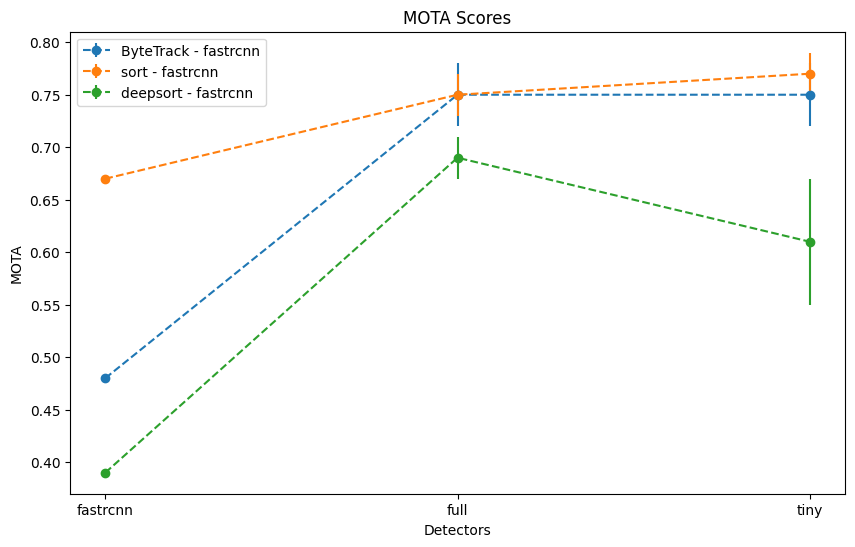

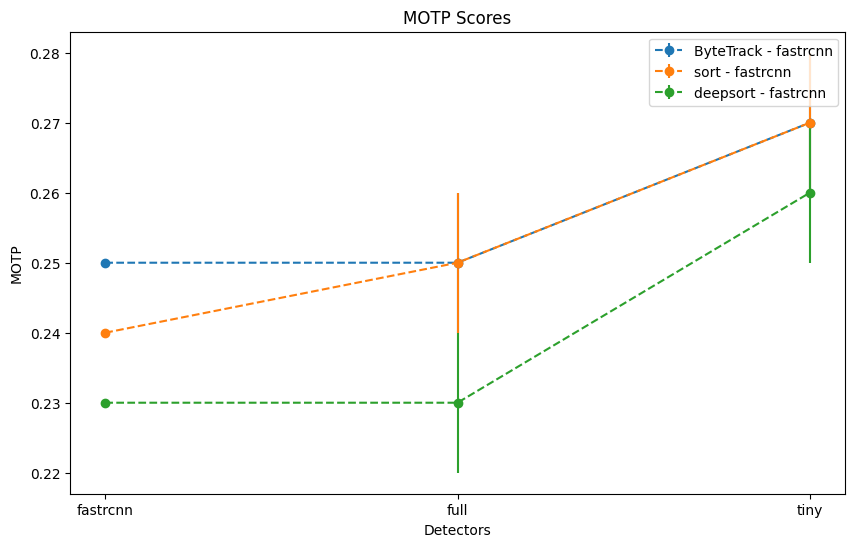

In [45]:
import matplotlib.pyplot as plt


prefixes = ['ByteTrack', 'sort', 'deepsort']
suffixes = ['fastrcnn', 'full', 'tiny']

def plot_metric(df: pd.DataFrame, metric_name: str) -> None:
    plt.figure(figsize=(10, 6))
    
    for prefix in prefixes:
        values = df.loc[[f"{prefix}-{suffix}" for suffix in suffixes]][metric_name]
        indexes = [v.split('-')[-1] for v in values.index]
        err = df.loc[[f"{prefix}-{suffix}" for suffix in suffixes]][f"{metric_name}-std"]
        #plt.plot(indexes, values.values, 'o--',  label=f"{prefix} - {suffix}")
        plt.errorbar(indexes, values, yerr=[v if v == v else 0 for v in err.values], 
                     label=f"{prefix} - {suffix}", marker='o', linestyle='--')
    
    plt.xlabel('Detectors')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Scores')
    plt.legend()
    plt.show()

print(df_city \
      .sort_values(by=['MOTA'], ascending=False) \
    .style.format("{:.2f}") \
    .set_sticky(axis="index") \
    .highlight_max(axis=0, 
                   subset=["IDF1", "IDP", "IDR", "Recall", "Precision", "MOTA", "MOTP"], 
                   props='font-weight: bold') \
    .highlight_min(axis=0,
                   subset=["# Switches", "Fragmentations", "FP", "FN"],
                   props='font-weight: bold') \
      .to_latex())
plot_metric(df_city, "MOTA")
plot_metric(df_city, "MOTP")

In [24]:
from IPython.display import HTML

HTML("""
<video width="800" controls>
  <source src="videos/city5-full-bt.mp4" type="video/mp4">
</video>
""")

In [31]:
HTML("""
<video width="800" controls>
  <source src="videos/city5-full-deepsort.mp4" type="video/mp4">
</video>
""")

In [25]:
HTML("""
<video width="800" controls>
  <source src="videos/city5-full-sort.mp4" type="video/mp4">
</video>
""")

# Tabela de Resultados pNEUMA

In [39]:
df_pNEUMA \
    .sort_values(by=['MOTA'], ascending=False) \
    .style.format("{:.2f}") \
    .set_sticky(axis="index") \
    .highlight_max(axis=0, 
                   subset=["IDF1", "IDP", "IDR", "Recall", "Precision", "MOTA", "MOTP"], 
                   props='font-weight: bold') \
    .highlight_min(axis=0,
                   subset=["# Switches", "Fragmentations", "FP", "FN"],
                   props='font-weight: bold')


,MOTA,MOTA-std,MOTP,MOTP-std,IDF1,IDF1-std,IDP,IDP-std,IDR,IDR-std,Recall,Recall-std,Precision,Precision-std,FP,FP-std,FN,FN-std,# Switches,# Switches-std,Fragmentations,Fragmentations-std
sort-tiny,0.48,0.04,0.30,0.00,0.55,0.04,0.63,0.05,0.49,0.03,0.64,0.02,0.82,0.04,7553.40,2270.78,19110.00,1269.45,615.60,69.87,1352.20,77.86
ByteTrack-tiny,0.47,0.04,0.30,0.00,0.59,0.03,0.66,0.05,0.54,0.02,0.65,0.02,0.80,0.04,8789.00,2562.22,18331.60,1202.77,989.40,49.08,1941.60,106.89
sort-full,0.39,0.04,0.29,0.00,0.50,0.04,0.63,0.04,0.42,0.04,0.54,0.04,0.80,0.03,7236.80,1366.66,24323.60,2174.40,547.80,51.55,1139.60,73.36
sort-fastrcnn,0.39,nan,0.29,nan,0.60,nan,0.58,nan,0.63,nan,0.74,nan,0.69,nan,17873.00,nan,13630.00,nan,502.00,nan,972.00,nan
ByteTrack-full,0.36,0.05,0.29,0.00,0.48,0.04,0.64,0.04,0.38,0.04,0.48,0.05,0.82,0.03,5803.20,1253.59,27250.40,2483.67,746.40,55.38,1258.00,78.39
deepsort-tiny,0.28,0.06,0.34,0.00,0.50,0.03,0.51,0.05,0.50,0.02,0.64,0.02,0.65,0.04,18235.20,3500.72,19040.60,1117.59,610.20,52.03,1639.80,64.56
ByteTrack-fastrcnn,0.28,nan,0.29,nan,0.61,nan,0.55,nan,0.68,nan,0.77,nan,0.62,nan,24335.00,nan,12369.00,nan,1192.00,nan,1360.00,nan
deepsort-full,0.25,0.05,0.34,0.00,0.46,0.04,0.49,0.04,0.43,0.04,0.57,0.03,0.65,0.03,16300.00,2744.13,22904.50,1717.49,615.33,66.79,1464.00,110.28
deepsort-fastrcnn,0.12,nan,0.32,nan,0.55,nan,0.48,nan,0.64,nan,0.74,nan,0.55,nan,31747.00,nan,13923.00,nan,536.00,nan,1227.00,nan


\begin{table}
\thead tr th:nth-child(1)sticky
\tbody tr th:nth-child(1)sticky
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrr}
 & MOTA & MOTA-std & MOTP & MOTP-std & IDF1 & IDF1-std & IDP & IDP-std & IDR & IDR-std & Recall & Recall-std & Precision & Precision-std & FP & FP-std & FN & FN-std & # Switches & # Switches-std & Fragmentations & Fragmentations-std \\
sort-tiny & \font-weightbold 0.48 & 0.04 & 0.30 & 0.00 & 0.55 & 0.04 & 0.63 & 0.05 & 0.49 & 0.03 & 0.64 & 0.02 & \font-weightbold 0.82 & 0.04 & 7553.40 & 2270.78 & 19110.00 & 1269.45 & 615.60 & 69.87 & 1352.20 & 77.86 \\
ByteTrack-tiny & 0.47 & 0.04 & 0.30 & 0.00 & 0.59 & 0.03 & \font-weightbold 0.66 & 0.05 & 0.54 & 0.02 & 0.65 & 0.02 & 0.80 & 0.04 & 8789.00 & 2562.22 & 18331.60 & 1202.77 & 989.40 & 49.08 & 1941.60 & 106.89 \\
sort-full & 0.39 & 0.04 & 0.29 & 0.00 & 0.50 & 0.04 & 0.63 & 0.04 & 0.42 & 0.04 & 0.54 & 0.04 & 0.80 & 0.03 & 7236.80 & 1366.66 & 24323.60 & 2174.40 & 547.80 & 51.55 & 1139.60 & 73.36 \\
sort-fastrcnn & 0.39 & nan 

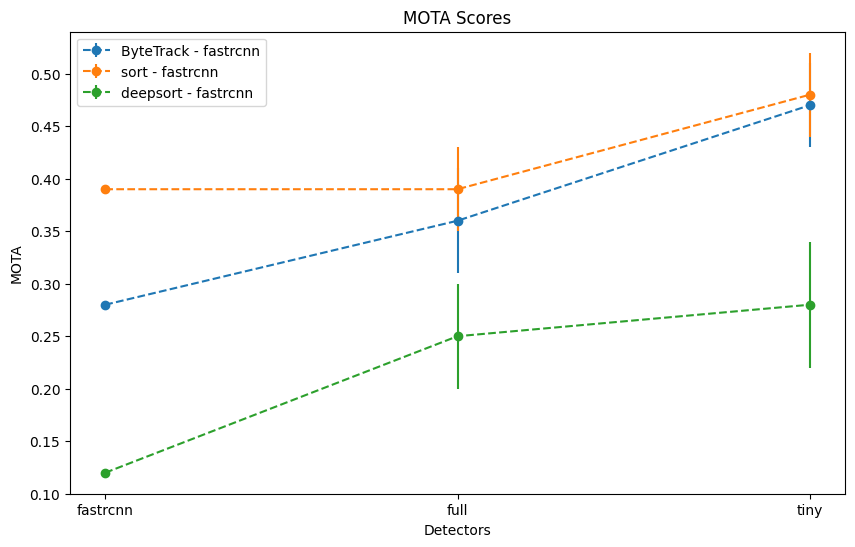

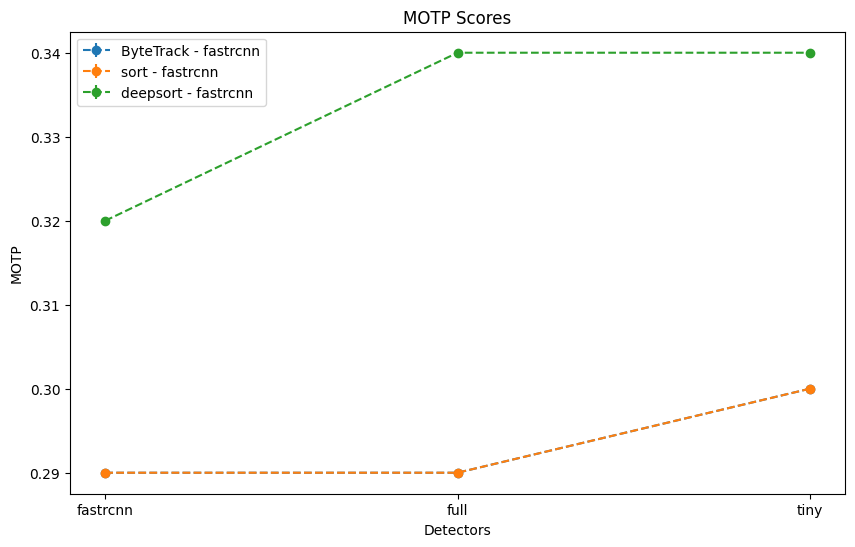

In [44]:
print(df_pNEUMA \
      .sort_values(by=['MOTA'], ascending=False) \
    .style.format("{:.2f}") \
    .set_sticky(axis="index") \
    .highlight_max(axis=0, 
                   subset=["IDF1", "IDP", "IDR", "Recall", "Precision", "MOTA", "MOTP"], 
                   props='font-weight: bold') \
    .highlight_min(axis=0,
                   subset=["# Switches", "Fragmentations", "FP", "FN"],
                   props='font-weight: bold') \
      .to_latex())
plot_metric(df_pNEUMA, "MOTA")
plot_metric(df_pNEUMA, "MOTP")

In [27]:
HTML("""
<video width="800" controls>
  <source src="videos/pneuma10-tiny-bt.mp4" type="video/mp4">
</video>
""")

In [30]:
HTML("""
<video width="800" controls>
  <source src="videos/pneuma10-tiny-deepsort.mp4" type="video/mp4">
</video>
""")

In [28]:
HTML("""
<video width="800" controls>
  <source src="videos/pneuma10-tiny-sort.mp4" type="video/mp4">
</video>
""")

Notamos que não houve muita diferença entro os modelos tiny e full da YOLOv7. É provavel que o modelo cheio da YOLO ainda não tenha convergido completamente, devido ao número limitado de iterações, enquanto que a versão tiny, por ser menor, esteja em um estado mais avançado de convergência.

Nota-se também que o Deep SORT teve uma performance pior que o SORT e ByteTrack. É provável que os resultados melhorem treinando um feature extractor específico para veículos. Apesar disso, o DeepSORT junto com a YOLO consegue melhores métricas que o SORT e ByteTrack utilizando a Fast RCNN como detector, provavelmente por conta da discrepancia na qualidade das detecções.

O ByteTrack mostrou-se superior ou igual ao SORT em todas métricas, especialmente em trocas de ID e fragmentações de trajetórias. Ele também mostra um desvio padrão mais baixo que os demais algoritmos na maioria das métricas.

O dataset do pNEUMA, apesar de não ter nenhum tipo de oclusão, se mostrou mais desafiador que o dataset da city_above. Tal fator provavelmente vem de seu baixo FPS e da distância da câmera aos veículos que desejamos detectar.

A _fastrcnn_ se saiu bem quando comparado a _YOLO_ na métrica de _recall_ e _IDR_, porém não se saiu tão bem no _MOTA_. É possível notar que sua quantidade de falsos positivos é significantemente maior que ambas as versões do _YOLO_, porém seu número de falsos negativos é significantemente menor. Uma análise estatística mais robusta pode ser feita treinando o modelo mais vezes e durante mais iterações.

É importante notar também que a _fastrcnn_ é significantemente mais lenta que a _YOLO_, levando mais que 1 segundo para processar um frame em uma P100.

Conseguimos ver que, na categoria de detecção e rastreamento, modelos mais leves podem ser utilizados para aplicações em tempo real de forma satisfatória.

# Trabalhos Futuros

É necessário treinar a versão cheia da YOLOv7 e Fast RCNN durante mais iterações para poder julgar de forma mais acurada sua performânce, bem como retreinar a Fast RCNN mais vezes. Outro importante ponto que deve ser levado em conta é o tempo de processamento de um quadro para cada modelo, que é essencial para aplicações em tempo real. Melhores datasets para validação de rastreamento de veículos também podem ser criados, contendo mais oclusões e situações diversas, como, por exemplo, vídeos realizados de noite ou durante tempo nublado e vias que passam em cima da outra.